<a href="https://colab.research.google.com/github/atrain29/Biomedical-Data-Science/blob/master/Biomedical_Data_Science_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Data download and unzipping
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget –quiet  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

if os.path.isdir('stage1_train'):
  !rm -rf 'stage1_train'
  
if os.path.isdir('stage1_test'):
  !rm -rf 'stage1_test'
  
!mkdir stage1_train stage1_test

!unzip -qq stage1_train.zip -d stage1_train/
!unzip -qq stage1_test.zip -d stage1_test/

--2018-12-04 04:28:08--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2018-12-04 04:28:13--  https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9545388 (9.1M) [application/zip]
Saving to: ‘stage1_test.zip’

stage1_test.zip     100%[===================>]   9.10M  18.1MB/s    in 0.5s    

2018-12-04 04:28:13 (18.1 MB/s) - ‘stage1_test.zip’ saved [9545388/9545388]

FINISHED --2018-12-04 04:28:13--
Total wall clock time: 5.6s
Downloaded: 1 files, 9.1M in 0.5s (18.1 MB/s)
--2018-12-04 04:28:15--  http://xn--quiet-xu3b/
Resolving xn--quiet-xu3b (xn--

In [0]:
# Downloading and intstalling keras
!pip -q install keras

In [3]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

Using TensorFlow backend.


In [0]:
# Tensor flow seeding
from tensorflow import set_random_seed
set_random_seed(seed)

In [0]:
# Data Path
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [0]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [0]:
# Function to read test images and return as numpy array
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test

In [0]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [11]:
# train_data
train_img,train_mask = read_train_data()

# test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
62/65 [===========================>..] - ETA: 0s

In [0]:
# u_net model
u_net = get_unet()

# Implement Early Stopping: Task #1

### need to change

In [0]:
import keras
stop_early = keras.callbacks.EarlyStopping(monitor='val_dice_coef',
                                           patience=8,
                                           mode='max')
# set max number of epochs
epochs=50

In [14]:
# fit model on train_data
print("\nTraining...")
history=u_net.fit(train_img,train_mask,validation_split=0.15,batch_size=16,epochs=epochs,callbacks=[stop_early])


Training...
Train on 569 samples, validate on 101 samples
Epoch 1/50
569/569 [==============================] - 22s 39ms/step - loss: 0.3778 - dice_coef: 0.2787 - val_loss: 0.1954 - val_dice_coef: 0.5701
Epoch 2/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1715 - dice_coef: 0.6763 - val_loss: 0.1412 - val_dice_coef: 0.7513
Epoch 3/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1228 - dice_coef: 0.7669 - val_loss: 0.1375 - val_dice_coef: 0.7471
Epoch 4/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1190 - dice_coef: 0.7714 - val_loss: 0.1139 - val_dice_coef: 0.8044
Epoch 5/50
569/569 [==============================] - 13s 22ms/step - loss: 0.1004 - dice_coef: 0.8119 - val_loss: 0.0910 - val_dice_coef: 0.8273
Epoch 6/50
569/569 [==============================] - 13s 22ms/step - loss: 0.0897 - dice_coef: 0.8302 - val_loss: 0.0919 - val_dice_coef: 0.8386
Epoch 7/50
569/569 [==============================] - 13s 22ms/st

In [15]:
print("Predicting")
# Predict on test data
test_mask = u_net.predict(test_img,verbose=1)

Predicting
65/65 [==============================] - 3s 42ms/step


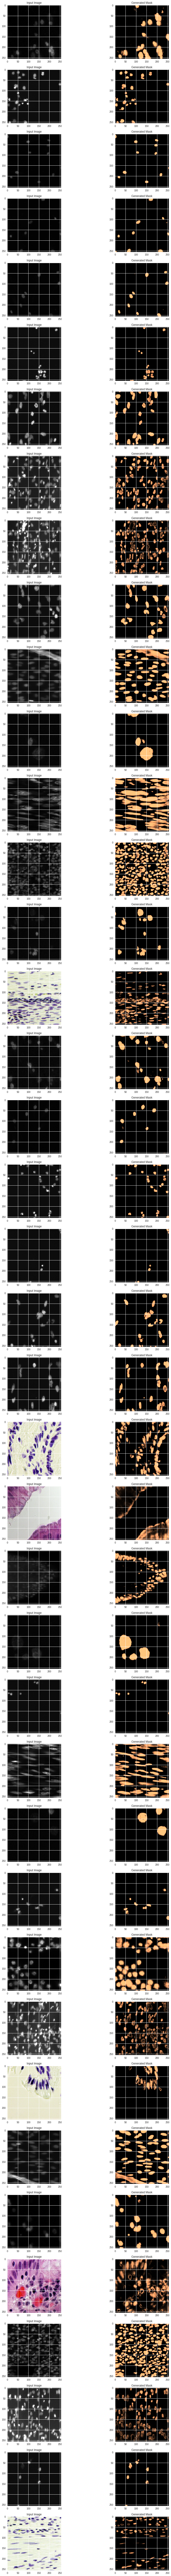

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,200))
for i in range(40):
    cur_test_mask=test_mask[i,:,:,0]
    cur_image=test_img[i]
    plt.subplot(40,2,(i+1)*2-1)
    plt.imshow(cur_image)
    plt.title('Input Image')
    plt.subplot(40,2,(i+1)*2)
    plt.imshow(cur_test_mask,cmap='copper')
    plt.title('Generated Mask')

In [17]:
last_dice_coef=history.history['val_dice_coef'][len(history.history['val_dice_coef'])-1]
print('val_dice_coef: %0.2f' %last_dice_coef)

val_dice_coef: 0.87


# Task #2

### insert code

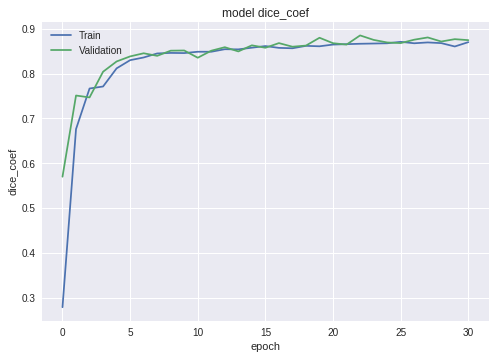

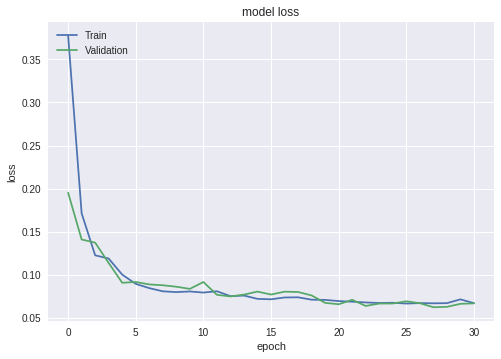

In [18]:
def plot_train_and_val(history):
  plt.plot(history.history['dice_coef'])
  plt.plot(history.history['val_dice_coef'])
  plt.title('model dice_coef')
  plt.ylabel('dice_coef')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

# call the function we just created to plot validation and test accuracy/loss 
plot_train_and_val(history)

In [0]:
# computes DICE for a given ground truth mask and predicted mask \n",
def calc_dice_coef(y_true, y_pred):
        intersection = np.sum(y_true * y_pred)
        return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
    
# this function finds the best and worst (#n_smaples) in terms of DICE score among all calculated DICE scores
def calc_best_and_worst_n_samples(training_set_dice_coefs,n_samples):
    best_n_samples=[]
    worst_n_samples=[]
    for i in range(n_samples):
        best_n_samples.append([np.amax(training_set_dice_coefs),np.argmax(training_set_dice_coefs)])
        worst_n_samples.append([np.amin(training_set_dice_coefs),np.argmin(training_set_dice_coefs)])
        training_set_dice_coefs[np.argmax(training_set_dice_coefs)]=np.mean(training_set_dice_coefs)
        training_set_dice_coefs[np.argmin(training_set_dice_coefs)]=np.mean(training_set_dice_coefs)
    for i in range(n_samples):
        training_set_dice_coefs[best_n_samples[i][1]]=best_n_samples[i][0]
        training_set_dice_coefs[worst_n_samples[i][1]]=worst_n_samples[i][0]
    return best_n_samples,worst_n_samples

# Task #3

#Insert code to complete #3 below. Feel free to add more cells to split up the code.

In [20]:
# Generate output predictions on training set
pred_mask = u_net.predict(train_img,verbose=1)

670/670 [==============================] - 6s 9ms/step


In [0]:
# Create list of dice coefficients
train_dice_coef=[]
for i in range(0,train_mask.shape[0]):
  train_dice_coef.append(calc_dice_coef(train_mask[i],pred_mask[i]))

In [0]:
# Calculate the indicies of the 5 best and worst samples
[best_n_samples,worst_n_samples]=calc_best_and_worst_n_samples(train_dice_coef,5)

In [0]:
# Create function to display best/worst 5 images
def display_image_and_masks(samples):
  rows=5
  cols=3
  plt.figure(figsize=(15,200/8))
  for i in list(range(0,rows)):
    j=samples[i][1]
    cur_ground_mask=train_mask[j,:,:,0]
    cur_pred_mask=pred_mask[j,:,:,0]
    cur_image=train_img[j]
    plt.subplot(rows,cols,(i+1)*3-2)
    plt.imshow(cur_image)
    plt.title('Input Image')
    plt.subplot(rows,cols,(i+1)*3-1)
    plt.imshow(cur_ground_mask,cmap='copper')
    plt.title('Ground Truth Mask')
    plt.subplot(rows,cols,(i+1)*3)
    plt.imshow(cur_pred_mask,cmap='copper')
    plt.title("Dice Coef: %.3f" %samples[i][0])
  return

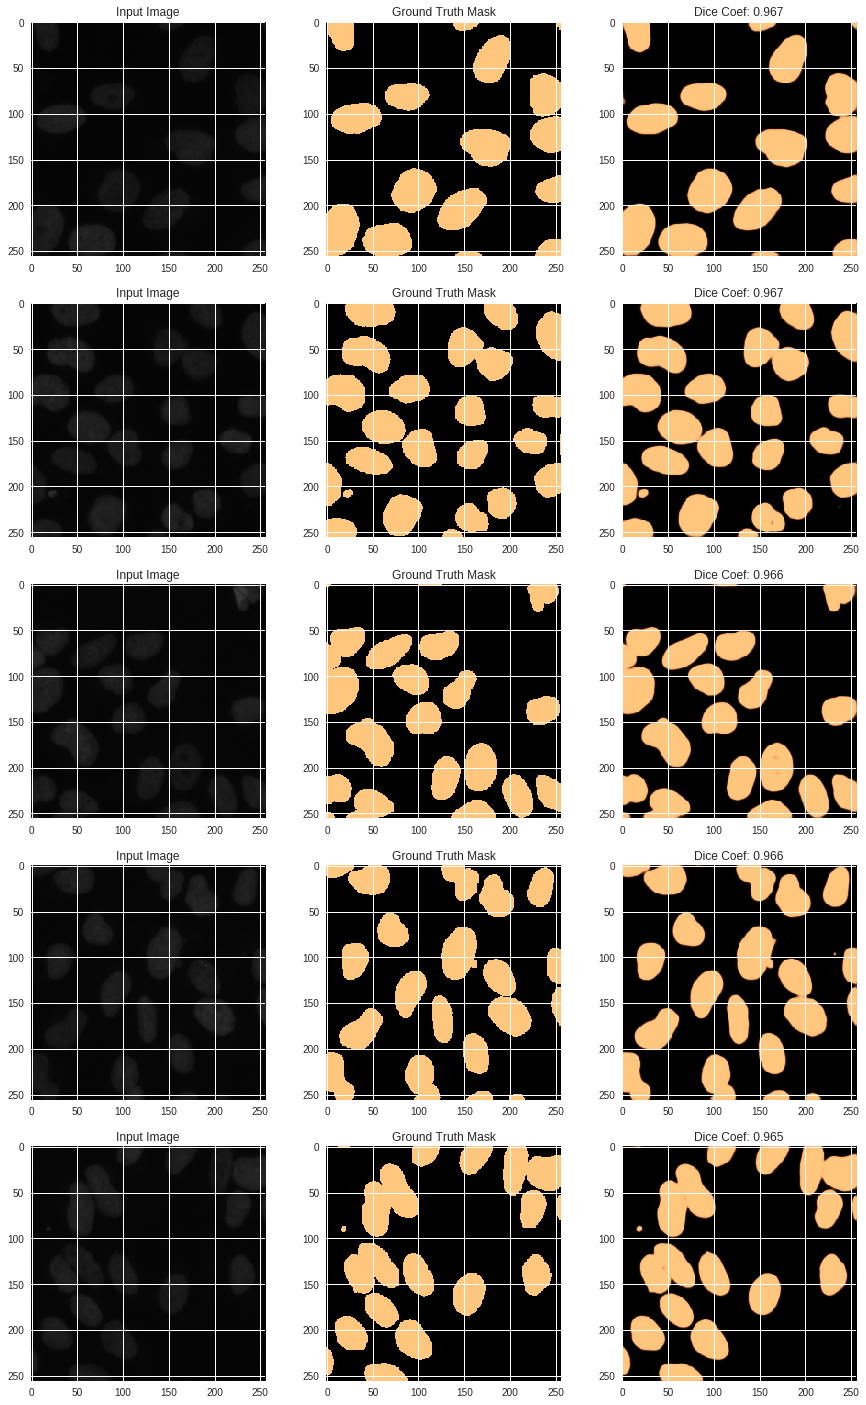

In [24]:
# Display best 5 images
  display_image_and_masks(best_n_samples)

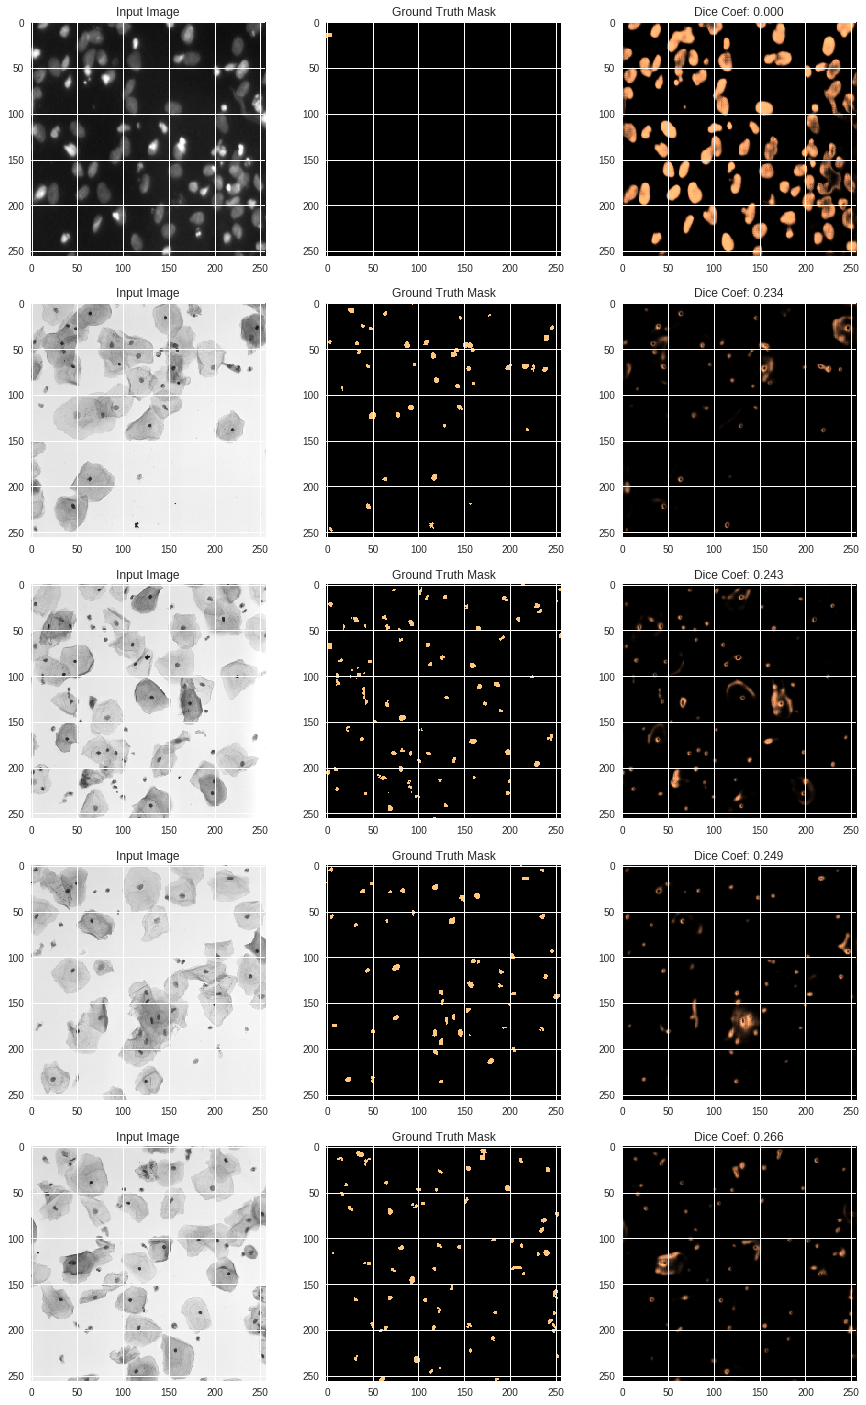

In [25]:
# Display 5 worst images
  display_image_and_masks(worst_n_samples)

#Insert your brief analysis for #3 below.

Looking at the best 5 images shown above, there are very large yellow drops scattered across the graph. The worst 5 images contain much smaller yellow droplets, but contain a higher volume of droplets when compared with the best 5 images. The best 5 images are well represented by completely solid regions with well defined borders in the Ground Truth Mask. There is a remarkable difference between input of the best 5 images and their Ground Truth Mask, displaying how well the code works for those input images.